### Techniques
- Temporal
- EGCI
- Autoencoding clustering
- Aux model embeddings (SurfPerch, Perch)
- Banding

In [3]:
# imports

import librosa
from datetime import datetime
import os

from pyha_analyzer import extractors

from utils import *
from models import AutoEncoder

import torch
import pandas as pd
import seaborn as sns
import sklearn

In [4]:
config = {
    'device': 'cuda',
    'num_dims': 10
}

In [5]:
# rev up the models
autoencoder_model = AutoEncoder(config['num_dims'], config['device'])
# 20240306_071700.WAV
timestamp_match = "%Y%m%d_%H%M%S.WAV"

In [6]:
# preprocessing

coralreef_extractor = extractors.MultiCoralReef()
coral_ads = coralreef_extractor('/home/a.jajodia.229/acoustic/local_data/coral')

ds = coral_ads['test']

min size is 15538 from dataset Paola
sampling 15538 from (Paola, 0)
sampling 15538 from (Paola, 1)
sampling 1294 from (Williams_et_al_2024, 0)
sampling 1294 from (Williams_et_al_2024, 1)
Loaded: 33664 samples


Casting the dataset:   0%|          | 0/23564 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3030 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7070 [00:00<?, ? examples/s]

In [7]:
# main processing loop

duration = 3

results = []

individual_labels = ['labels', 'dataset']

for idx in range(100):
    row = ds[idx]
    filepath = row['filepath']
    sample_rate = row['sample_rate']
    filename = os.path.basename(filepath)
    
    extra_labels = {key:row[key] for key in individual_labels}
    
    audios = get_audio_split(filepath, duration)
    
    # timestamp = datetime.strptime(filename, timestamp_match)
    
    # print(timestamp)
    
    for i, audio in enumerate(audios):
        melspectrogram = get_melspec(audio, sample_rate=sample_rate)
        
        entropy, complexity = EGCI(audio, 256)
        
        # surfperch_embedding = 
        
        autoencoder_embedding = autoencoder_model.embed(torch.tensor(melspectrogram).unsqueeze(0))
        
        autoencoder_embedding_vals = {"ae"+str(i):autoencoder_embedding[i] for i in range(config["num_dims"])}
        
        result = {
            "entropy": entropy,
            "complexity": complexity,
            "chunk_num": i
        }
        result.update(extra_labels)
        result.update(autoencoder_embedding_vals)
        
        results.append(result)

In [8]:
df = pd.DataFrame.from_records(results)
df["isDegraded"] = df['labels'].astype(str) == "[1, 0]"

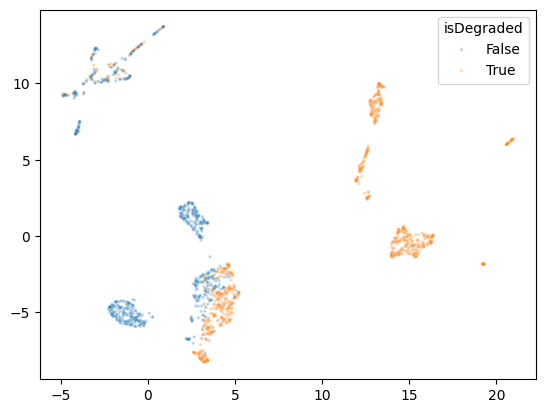

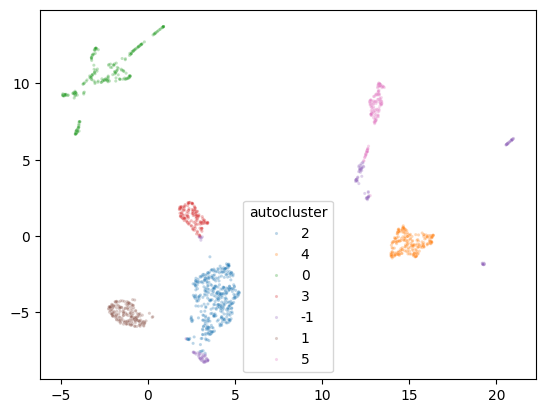

In [44]:
# clustering by autoencoding
from sklearn.preprocessing import StandardScaler

import umap

reducer = umap.UMAP()
autoarray = StandardScaler().fit_transform(df[[s for s in df.columns.to_list() if "ae" in s]].to_numpy())
auto_reduced = reducer.fit_transform(autoarray)


sns.scatterplot(x=auto_reduced[:, 0], y=auto_reduced[:, 1], hue=df['isDegraded'], s=5, alpha=0.3)
plt.show()

clustering = sklearn.cluster.HDBSCAN(min_cluster_size=100).fit_predict(auto_reduced)

df["autocluster"] = clustering
df["autocluster"] = df["autocluster"].astype(str)

sns.scatterplot(x=auto_reduced[:, 0], y=auto_reduced[:, 1], hue=df['autocluster'], s=5, alpha=0.3)
plt.show()


100%|██████████| 1633/1633 [00:03<00:00, 439.94it/s]


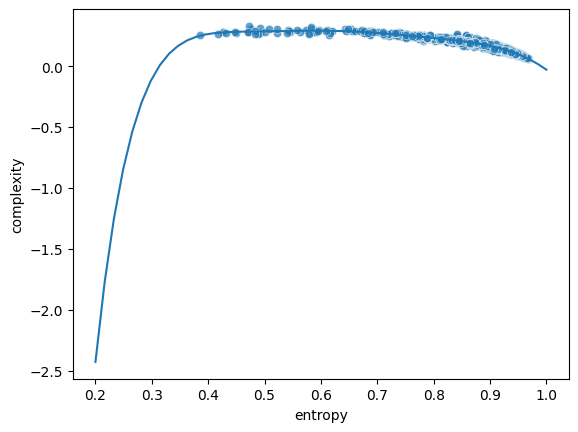

In [22]:
# clustering (we hardcode cluster values until we actually have a better way to cluster)
# using spectral clustering from Scikit-learn
from scipy.optimize import minimize

# clustering = sklearn.cluster.SpectralClustering(n_clusters=5,
#         assign_labels='discretize',
#         random_state=0).fit(df[["entropy", "complexity"]])

# df['egci_clusters'] = clustering.labels_
# sns.scatterplot(x=df["entropy"], y=df["complexity"], hue=df['egci_clusters'], alpha=0.7)
# plt.show()

points = np.array([df["entropy"], df["complexity"]]).T

f = np.poly1d(np.polyfit(points[:, 0], points[:, 1],7))

sns.scatterplot(x=df["entropy"], y=df["complexity"], 
                # hue=df['egci_clusters'],
                alpha=0.7)
plt.plot(np.linspace(0.2, 1).reshape(-1,1), f(np.linspace(0.2, 1)).reshape(-1,1))


dist = []
for point in tqdm(points):
    # Function to minimize: squared distance
    def squared_distance(x):
        return sum((x - point[0])**2 + (f(x) - point[1])**2)

    # Initial guess for x (can be important for convergence)
    x0 = 0.5 # A reasonable starting point

    # Use a numerical optimizer to find the x that minimizes the squared distance
    result = minimize(squared_distance, x0)

    delta_y = np.sqrt(result.fun)
    
    if f(result.x[0]) < point[1] :
        dist.append(delta_y)
    else:
        dist.append(delta_y * -1)
dist = np.array(dist)

In [24]:
normalize = lambda e: (e-e.min())/(e.max()-e.min())

# normalize = lambda e: e

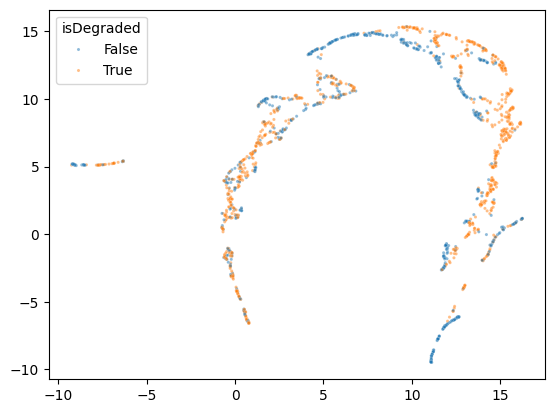

/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning:

Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.



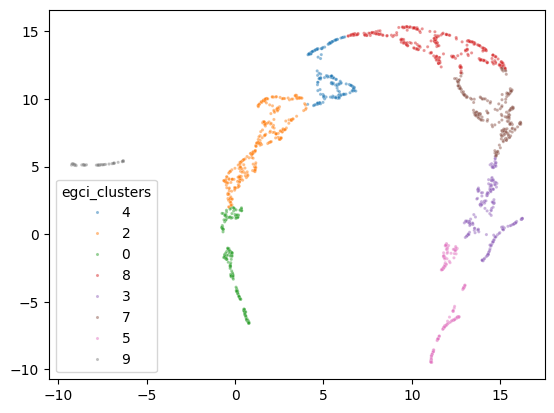

In [48]:
import plotly.express as px

egci_points = StandardScaler().fit_transform(np.concat([points[:,0].reshape(-1,1), points[:,1].reshape(-1,1), normalize(dist.reshape(-1,1))], axis=1))
egci_points = reducer.fit_transform(egci_points)



sns.scatterplot(x=egci_points[:, 0], y=egci_points[:, 1], hue=df['isDegraded'], s=5, alpha=0.5)
plt.show()


clustering = sklearn.mixture.BayesianGaussianMixture(n_components=10).fit_predict(egci_points)


df['egci_clusters'] = clustering.astype(str)

sns.scatterplot(x=egci_points[:, 0], y=egci_points[:, 1], hue=df['egci_clusters'], s=5, alpha=0.5)
plt.show()

In [ ]:
df.to_csv("output.csv")